## Proyecto en Grupo – Regresión Avanzada<br>*Predicción de Precios de Bienes Raíces en Australia*

---
**Integrantes:**
- Carlos Andrés Pérez Guzmán

## Índice


- [Índice](#índice)
- [Introducción](#introducción)
  - [Métodos Utilizados](#métodos-utilizados)
  - [Tecnologías](#tecnologías)
- [Descarga y Configuración](#descarga-y-configuración)
  - [Requisitos Previos](#requisitos-previos)
  - [Cómo Ejecutar](#cómo-ejecutar)
- [Declaración del Problema](#declaración-del-problema)
  - [Objetivo Comercial](#objetivo-comercial)
  - [Preparación de Datos:](#preparación-de-datos)
  - [Construcción y Evaluación del Modelo](#construcción-y-evaluación-del-modelo)
  - [Conclusiones](#conclusiones)
    - [Regresión Ridge](#regresión-ridge)
    - [Regresión Lasso](#regresión-lasso)
    - [Regresión ElasticNet](#regresión-lasso)
    - [Las Variables Más Significativas Son:](#las-variables-más-significativas-son)


### Introducción


...


#### Métodos Utilizados
...


#### Tecnologías
* Python
* Pandas
...


### Descarga y Configuración
#### Requisitos Previos

Este proyecto necesita que Anaconda esté instalado en la computadora.


Para más detalles sobre la instalación, visite: https://docs.anaconda.com/anaconda/install/index.html


#### Cómo Ejecutar


Puede descargar el código fuente clonando este repositorio usando Git:


1. Abra su aplicación Terminal favorita (Unix, Linux o Macos), como Terminal, Comando, Consola, iTerm2, etc.


2. Clone el repositorio


```
git clone <GITHUB_REPO_URL>
```


3. Abra el archivo notebook ** *.ipynb** en Anaconda.


```
jupyter notebook <FILE.ipynb
```




### Declaración del Problema


...


#### Objetivo Comercial


...


---



### **Preparación de Datos**


#### 1. Limpieza de Datos y Análisis de Datos Faltantes.

Librerías

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

Limpieza de información

In [25]:
import polars as pl

data = pl.read_csv(
    source='./Data/dataset.csv',
    infer_schema=False,
    null_values=['NA', '', ' ', '-', 'null']
)

mapping_char = {'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U', 'Ü': 'U'}

# Limpieza de texto
data = data\
    .with_columns(
        pl.all()
        .str.to_uppercase()
        .str.replace_all(r'\s+', ' ')
        .str.strip_chars()
        .str.replace_many(mapping_char)
    )\
    .select(pl.all().replace({' ': None}))

In [26]:
# Verificar calidad de información
data\
    .null_count()\
    .transpose( include_header = True )\
    .with_columns( (pl.col("column_0") / total_rows * 100).alias("null_percentage") )\
    .filter( pl.col('column_0') > 0 )\
    .sort('column_0', descending = True)

column,column_0,null_percentage
str,u32,f64
"""PoolQC""",1453,99.520548
"""MiscFeature""",1406,96.30137
"""Alley""",1369,93.767123
"""Fence""",1179,80.753425
"""FireplaceQu""",690,47.260274
…,…,…
"""BsmtCond""",37,2.534247
"""BsmtFinType1""",37,2.534247
"""MasVnrType""",8,0.547945


In [27]:
# Exportar archivo mejorado
#data.write_parquet( file = './Data/data.parquet', compression = 'lz4' )
data.write_csv(file = './Data/data.csv', separator = ';')

Carga de información

In [28]:
data = pd.read_csv ( filepath_or_buffer = './Data/data.csv', sep = ';' )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [29]:
# Convertir variables categóricas en variables numéricas usando One-Hot Encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Definir variable objetivo y características
X = data_encoded.drop('SalePrice', axis=1, errors='ignore')
y = data_encoded['SalePrice']

# Imputar valores faltantes con la media de cada columna
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 1. Selección basada en correlación
# Calcular la correlación con la variable objetivo y seleccionar características con alta correlación
correlation_matrix = data_encoded.corr()
correlation_with_target = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)

# Seleccionar características con una correlación mayor a 0.6 como umbral
correlated_features = correlation_with_target[correlation_with_target > 0.5].index.tolist()
correlated_features.remove('SalePrice')

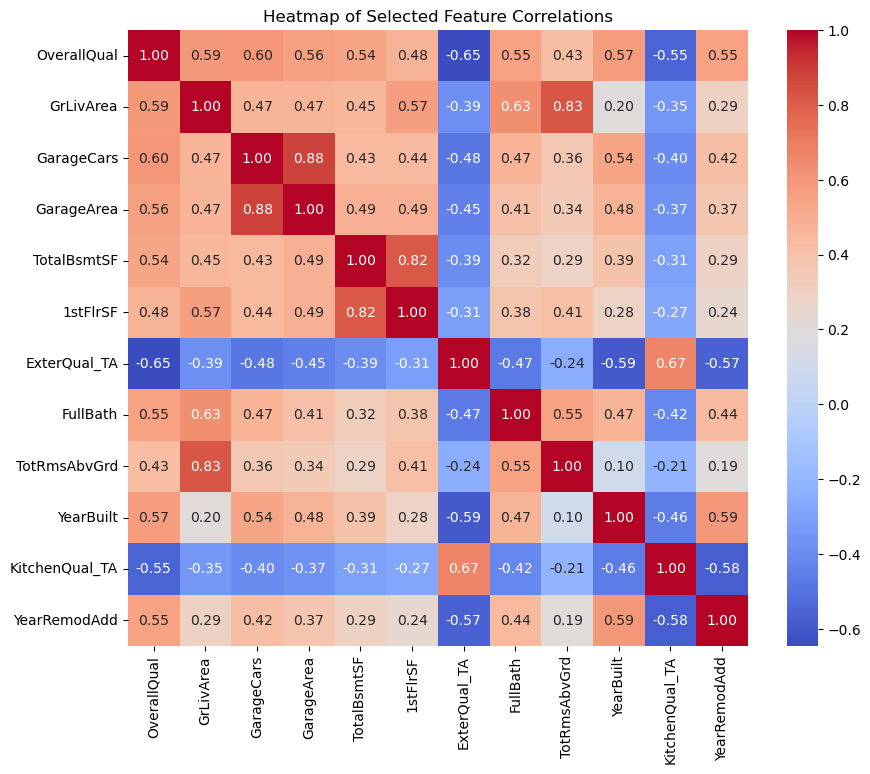

In [30]:

# Crear matriz de correlación para estas características
selected_corr_matrix = data_encoded[correlated_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Selected Feature Correlations")
plt.show()

#### 2. Modelos de Regresión y Regularización

#### Linear Regression

Mean Squared Error (MSE): 1559299894.954661
R² Score: 0.7967100938297004
Prediction Accuracy: 79.67100938297004%


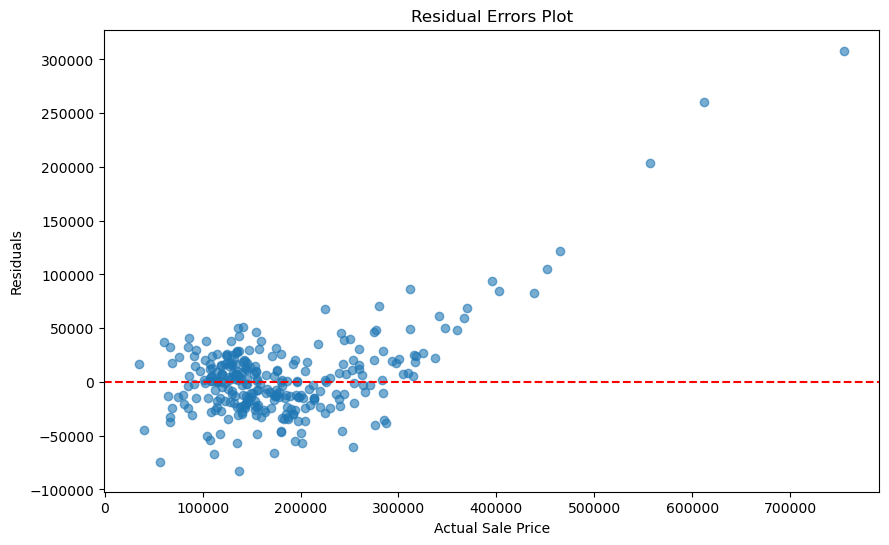

In [31]:
# 2. Dividir el conjunto de datos en entrenamiento y prueba
X_selected = data_encoded[correlated_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = model.score(X_test, y_test) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print(f"Prediction Accuracy: {accuracy}%")

# Graficar los errores residuales
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Residuals")
plt.title("Residual Errors Plot")
plt.show()

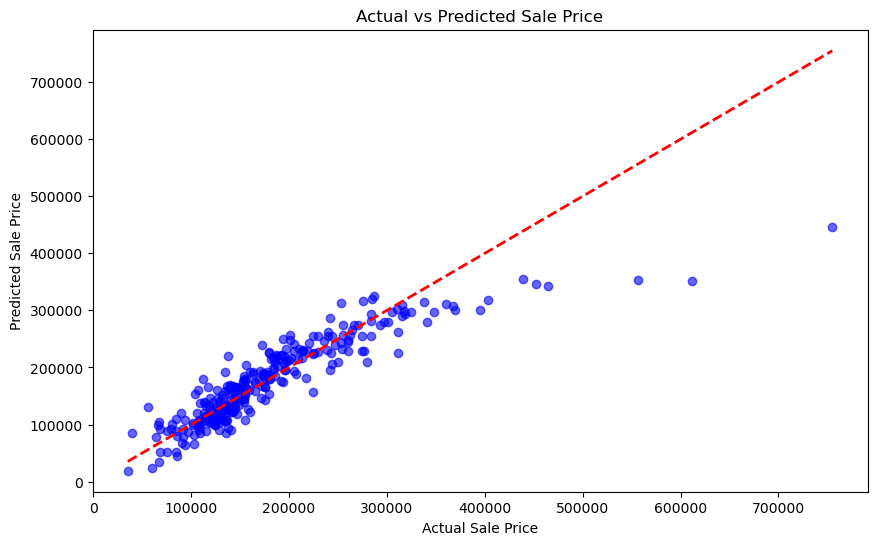

'SalePrice = -973525.95 + (18095.92) * OverallQual + (46.28) * GrLivArea + (11333.58) * GarageCars + (13.51) * GarageArea + (14.19) * TotalBsmtSF + (15.65) * 1stFlrSF + (-6795.96) * ExterQual_TA + (-8097.72) * FullBath + (996.59) * TotRmsAbvGrd + (256.20) * YearBuilt + (-7564.91) * KitchenQual_TA + (213.02) * YearRemodAdd '

In [32]:
# Obtener los coeficientes y el intercepto del modelo
coefficients = model.coef_
intercept = model.intercept_

# Crear una gráfica de dispersión de los valores reales frente a los valores predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Price")

# Mostrar la gráfica
plt.show()

# Crear la ecuación del modelo como una cadena
equation = f"SalePrice = {intercept:.2f} "
for i, coef in enumerate(coefficients):
    equation += f"+ ({coef:.2f}) * {correlated_features[i]} "

equation

#### RIDGE

In [33]:
# Convertir variables categóricas en variables numéricas usando One-Hot Encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Definir variable objetivo y características
X = data_encoded.drop('SalePrice', axis=1, errors='ignore')
y = data_encoded['SalePrice']

# Imputar valores faltantes con la media de cada columna
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Selección basada en correlación (>0.5 con SalePrice)
correlation_matrix = data_encoded.corr()
correlation_with_target = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)
correlated_features = correlation_with_target[correlation_with_target > 0.5].index.tolist()
correlated_features.remove('SalePrice')

In [34]:
# Seleccionar características y dividir datos
X_selected = data_encoded[correlated_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Configurar el modelo Ridge con GridSearchCV para encontrar el mejor alpha
alpha_range = np.logspace(-3, 3, 50)
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid={'alpha': alpha_range}, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)

# Obtener el mejor alpha y el modelo
best_alpha = ridge_cv.best_params_['alpha']
ridge_best_model = ridge_cv.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred_ridge = ridge_best_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Mejor valor de alpha: {best_alpha}")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"R² Score: {r2_ridge}")


Mejor valor de alpha: 79.06043210907701
Mean Squared Error (MSE): 1554704606.5310607
R² Score: 0.7973091933072812


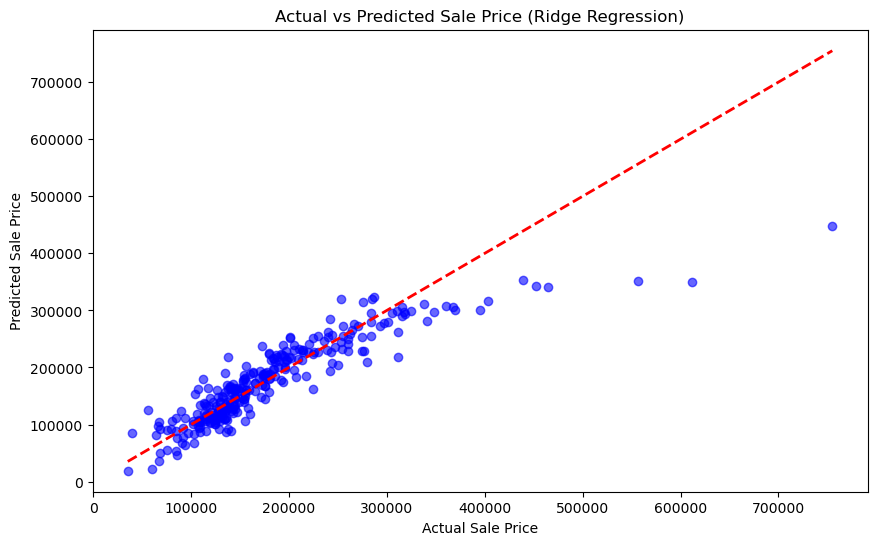

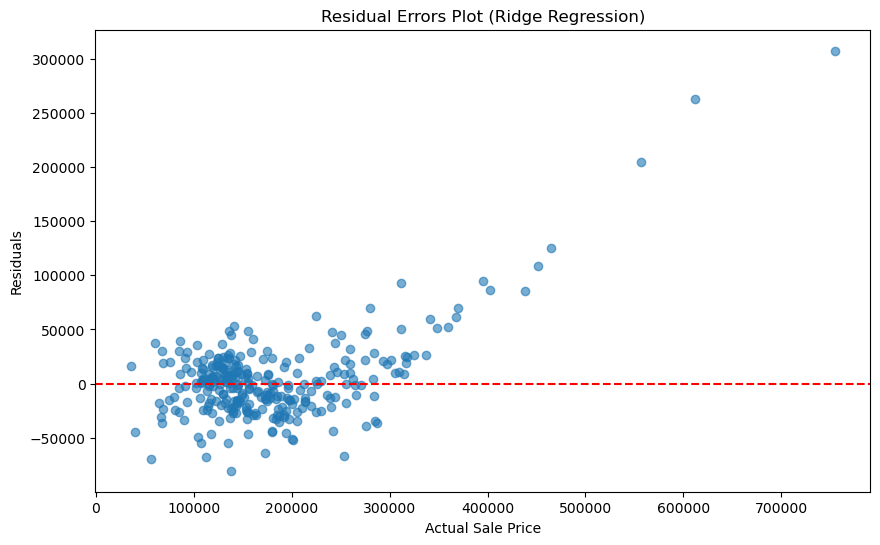

In [35]:

# Graficar Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Price (Ridge Regression)")
plt.show()

# Graficar errores residuales
residuals = y_test - y_pred_ridge
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Residuals")
plt.title("Residual Errors Plot (Ridge Regression)")
plt.show()

#### LASSO

Train R^2: 0.77
Test R^2: 0.80
Train MSE: 1384383288.90
Test MSE: 1559311179.68


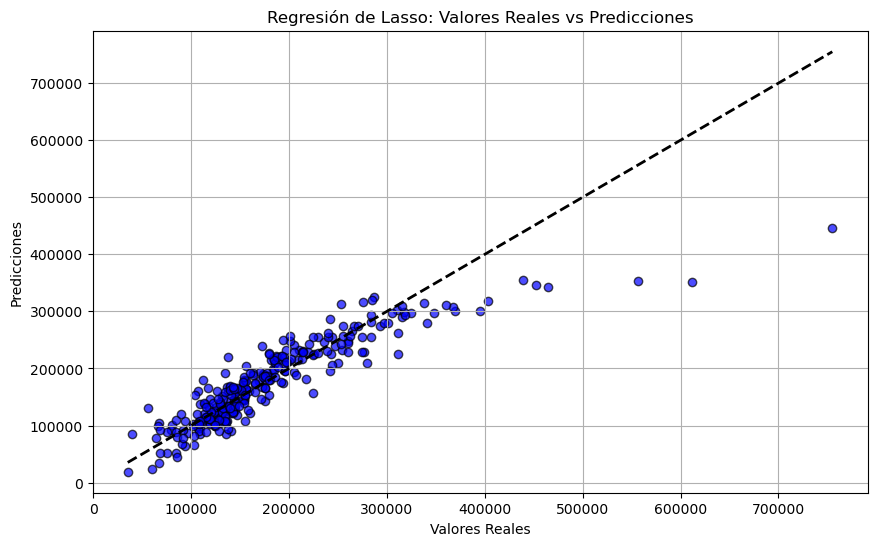

In [36]:
# Importar Librerias Requeridas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ignorar Alertas (Warnings)
import warnings
warnings.filterwarnings('ignore')

# Definir precision del FLOAT a dos digitos.
pd.options.display.float_format = '{:.2f}'.format

# Supongamos que ya tienes X_train, X_test, y_train, y_test definidos
# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo de regresión de Lasso
lasso = Lasso(alpha=1.0)  # Puedes ajustar el parámetro alpha según sea necesario
lasso.fit(X_train_scaled, y_train)

# Realizar predicciones
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# Evaluar el modelo
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Train R^2: {train_r2:.2f}')
print(f'Test R^2: {test_r2:.2f}')
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Regresión de Lasso: Valores Reales vs Predicciones')
plt.grid(True)
plt.show()

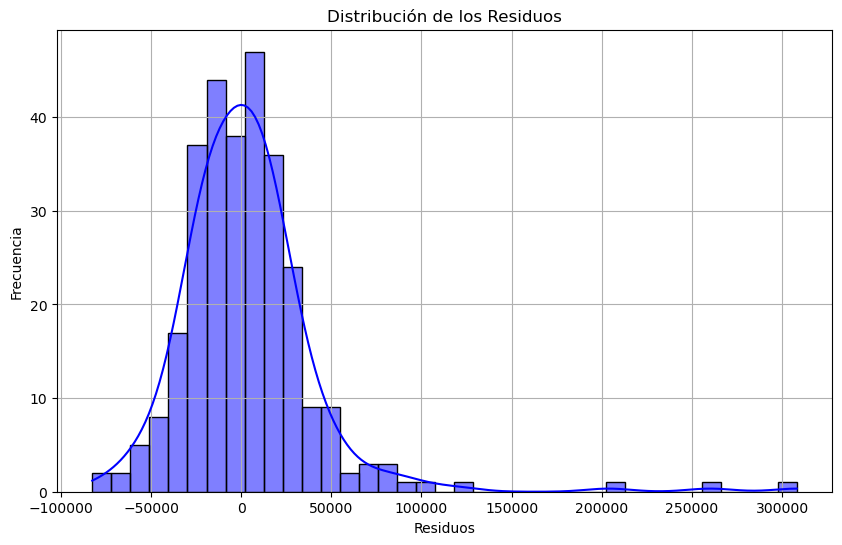

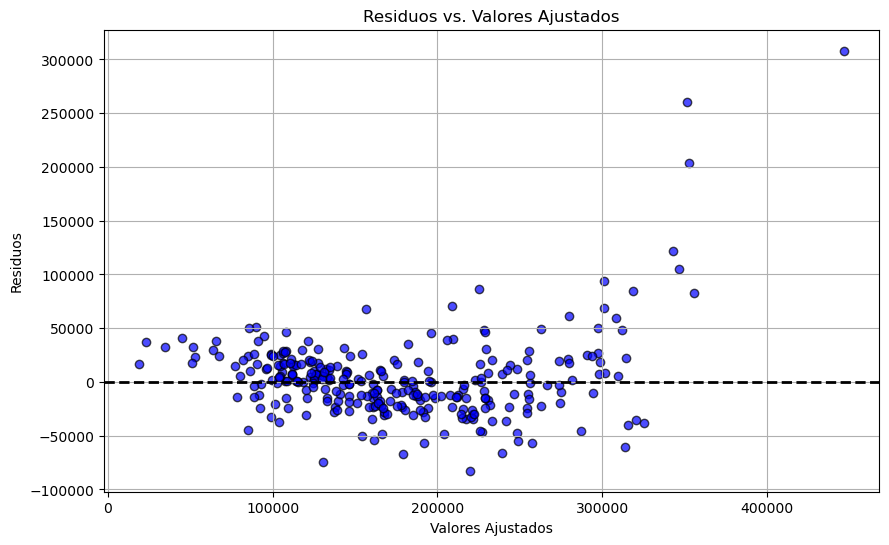

In [37]:
# Distribución de los Residuos
residuos = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True, color='blue')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de los Residuos')
plt.grid(True)
plt.show()

# Gráfica de Residuos vs. Valores Ajustados
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuos, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs. Valores Ajustados')
plt.grid(True)
plt.show()



#### 3. Derivación de Columnas Categóricas.


#### 4. Análisis Univariable.


#### 5. Análisis Bivariable.


#### 6. Análisis Multivariable.


### Construcción y Evaluación del Modelo


1. División de datos de entrenamiento y prueba.
2. Escalado de Características - StandardScaler.
3. Ingeniería y Selección de Características usando RFE y el Factor de Inflación de Varianza.
4. Preparación del modelo usando OLS & Regresión Lineal.
5. Modelos de Regularización Ridge, Lasso y ElasticNet.
6. Análisis de Residuos.
7. Evaluación y Valoración del Modelo.
8. Predicción.
9. Conclusión y Análisis Final.


### Conclusiones


### Conclusions


R2_Score for Ridge regresion.... 
R2_Score for Lasso regresion.... 
R2_Score for ElasticNet regresion.... 


#### Ridge Regression
* **Optimal Lambda Value:** ##
* **R2 Score Train:** 0.##
* **R2 Test Score:**  0.##
* **RMSE Test:**      0.##


#### Lasso Regression
* **Optimal Lambda Value:** 0.####
* **R2 Score Train:**  0.##
* **R2 Test Score:**   0.##
* **RMSE Test:**       0.##


#### ElasticNet Regression
* **Optimal Lambda Value:** 0.####
* **R2 Score Train:**  0.##
* **R2 Test Score:**   0.##
* **RMSE Test:**       0.##


#### Las Variables Más Significativas Son:
* ...
* ...
* ...
* ...
